In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

import pickle

In [2]:
df = pd.read_csv('loan_data.csv', sep=';')
df.head()

,person_income,person_emp_exp,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,tenure
0,80000,7,10000,EDUCATION,963,12,30,598,No,1,7
1,80000,0,10000,VENTURE,964,12,40,630,No,1,2
2,80000,5,10000,EDUCATION,964,12,40,631,No,1,6
3,80000,0,12000,MEDICAL,1426,15,20,687,No,1,6
4,80000,9,12000,PERSONAL,1273,15,90,580,No,1,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44896 entries, 0 to 44895
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   person_income                   44896 non-null  int64 
 1   person_emp_exp                  44896 non-null  int64 
 2   loan_amnt                       44896 non-null  int64 
 3   loan_intent                     44896 non-null  object
 4   loan_int_rate                   44896 non-null  int64 
 5   loan_percent_income             44896 non-null  int64 
 6   cb_person_cred_hist_length      44896 non-null  int64 
 7   credit_score                    44896 non-null  int64 
 8   previous_loan_defaults_on_file  44896 non-null  object
 9   loan_status                     44896 non-null  int64 
 10  tenure                          44896 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 3.8+ MB


In [4]:
df.describe()

,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,tenure
count,4.489600e+04,44896.000000,44896.000000,44896.000000,44896.000000,44896.000000,44896.000000,44896.000000,44896.000000
mean,7.813875e+05,5.382818,95732.101301,1033.286106,12.719953,58.525036,632.574149,0.222425,5.009689
std,4.751866e+05,5.988078,63044.504147,383.029815,9.104724,38.611070,50.405357,0.415880,2.239282
min,8.000000e+04,0.000000,5000.000000,55.000000,0.000000,20.000000,390.000000,0.000000,0.000000
25%,4.713500e+05,1.000000,50000.000000,778.000000,6.000000,30.000000,601.000000,0.000000,3.000000
50%,6.701500e+05,4.000000,80000.000000,1101.000000,11.000000,40.000000,640.000000,0.000000,5.000000
75%,9.528125e+05,8.000000,122000.000000,1285.000000,18.000000,80.000000,670.000000,0.000000,6.000000
max,4.989070e+06,125.000000,350000.000000,1991.000000,66.000000,300.000000,807.000000,1.000000,16.000000


In [5]:
df.duplicated().sum()

0

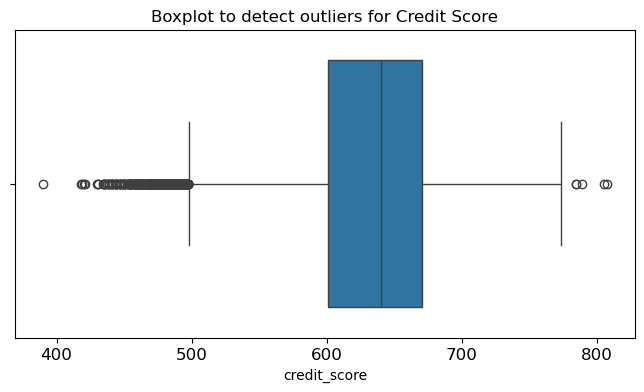

In [6]:
plt.figure(figsize=(8,4))
plt.title('Boxplot to detect outliers for Credit Score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['credit_score'])
plt.show();

In [7]:
percentile25 = df['credit_score'].quantile(0.25)
percentile75 = df['credit_score'].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

outliers = df[(df['credit_score'] > upper_limit) | (df['credit_score'] < lower_limit)]

print("Number of rows in the data containing outliers in credit score:", len(outliers))

Lower limit: 497.5
Upper limit: 773.5
Number of rows in the data containing outliers in credit score: 464


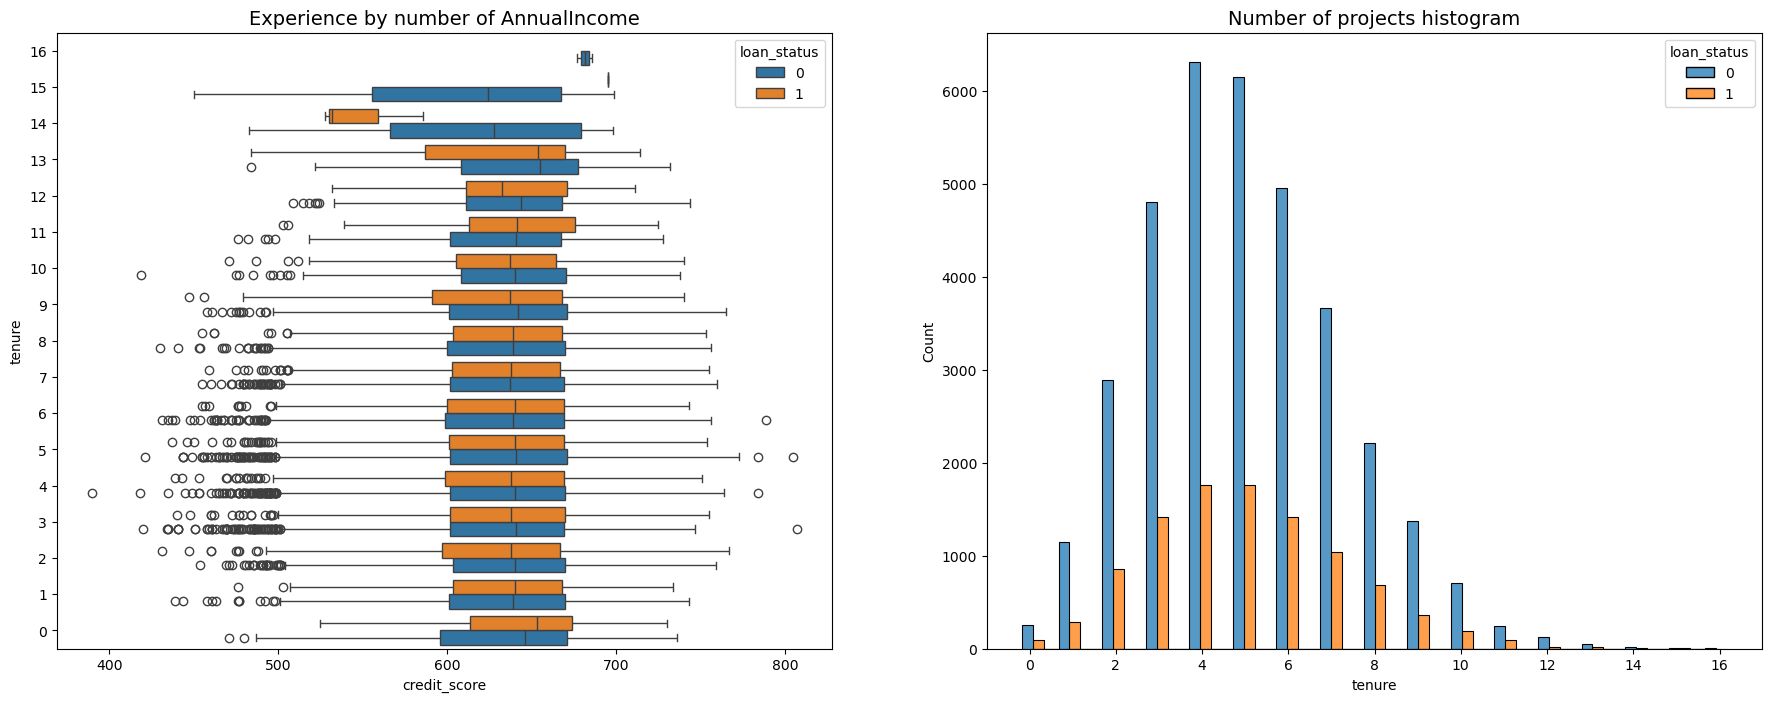

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

sns.boxplot(data=df, x='credit_score', y='tenure', hue='loan_status', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Experience by number of AnnualIncome', fontsize='14')

loan_rejected = df[df['loan_status']==0]['tenure']
loan_accepted = df[df['loan_status']==1]['tenure']
sns.histplot(data=df, x='tenure', hue='loan_status', shrink=3, multiple='dodge', ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show();

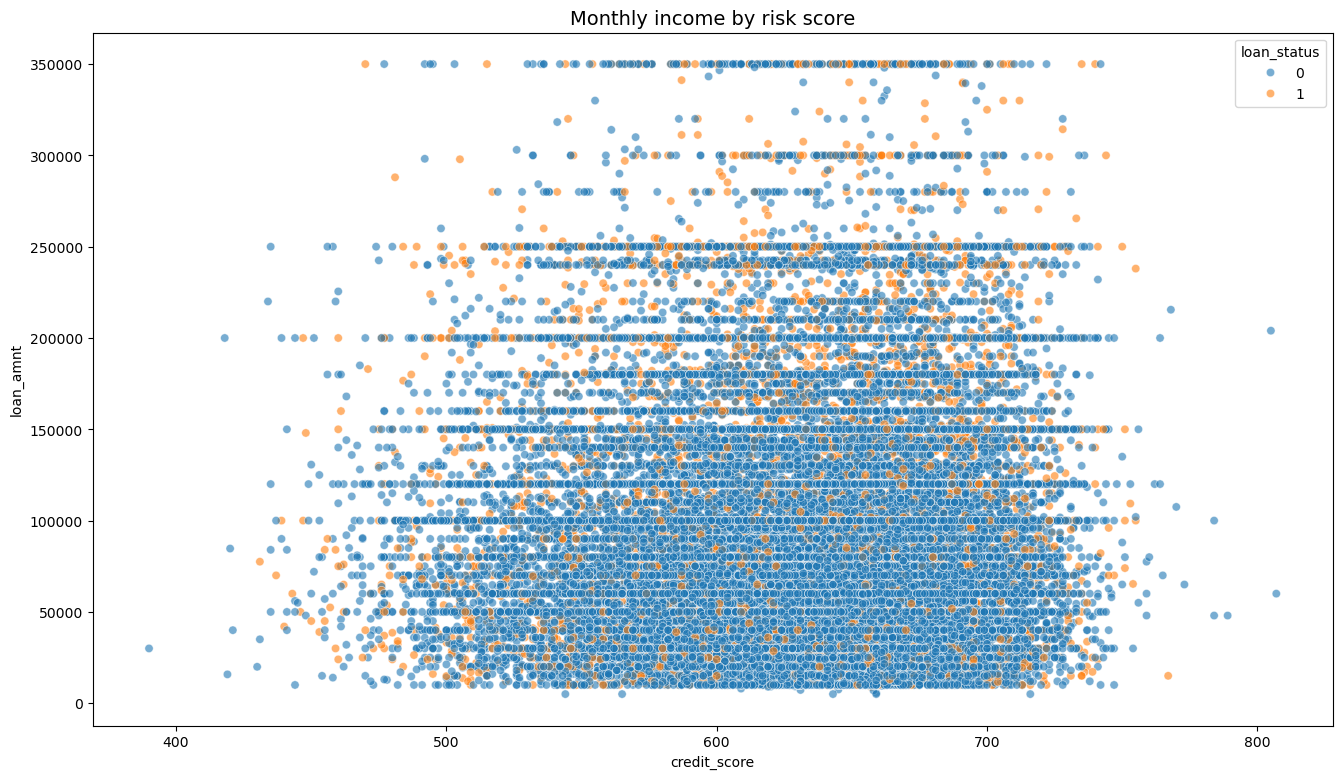

In [9]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='credit_score', y='loan_amnt', hue='loan_status', alpha=0.6)
plt.title('Monthly income by risk score', fontsize='14')
plt.show();

In [10]:
df.groupby(['loan_status'])['tenure'].agg(['mean', 'median'])

,mean,median
loan_status,,
0,5.011401,5.0
1,5.003705,5.0


In [11]:
def classify_income(income):
    if income < 200000:
        return 'low'
    elif 200000 <= income < 300000:
        return 'medium'
    else:
        return 'high'

# Terapkan fungsi klasifikasi pada kolom person_income
df['income_class'] = df['person_income'].apply(classify_income)

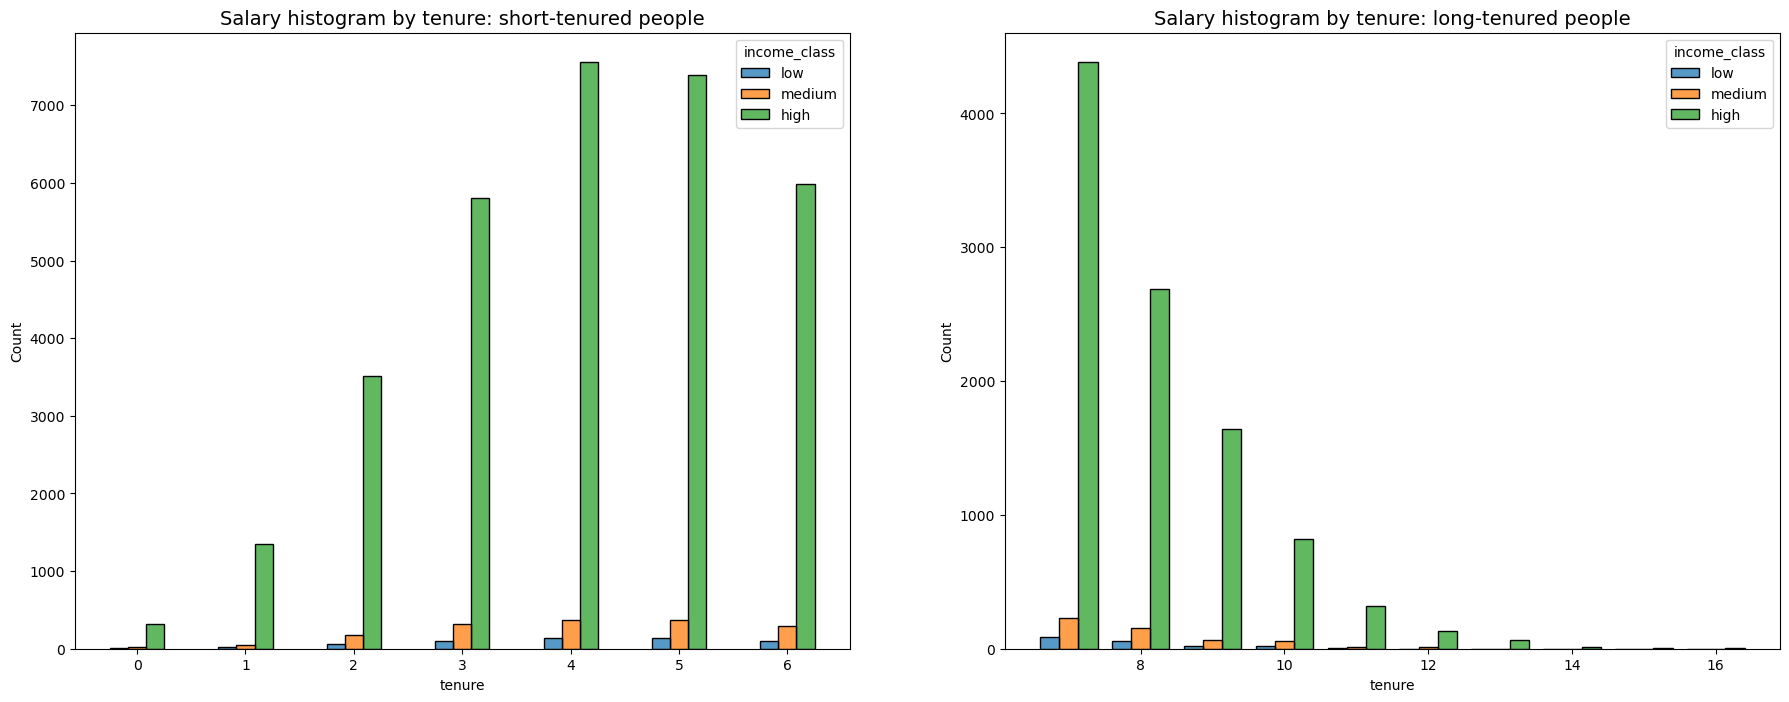

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (22,8))

tenure_short = df[df['tenure'] < 7]

tenure_long = df[df['tenure'] > 6]

sns.histplot(data=tenure_short, x='tenure', hue='income_class', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured people', fontsize='14')

sns.histplot(data=tenure_long, x='tenure', hue='income_class', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.8, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured people', fontsize='14');

plt.show();

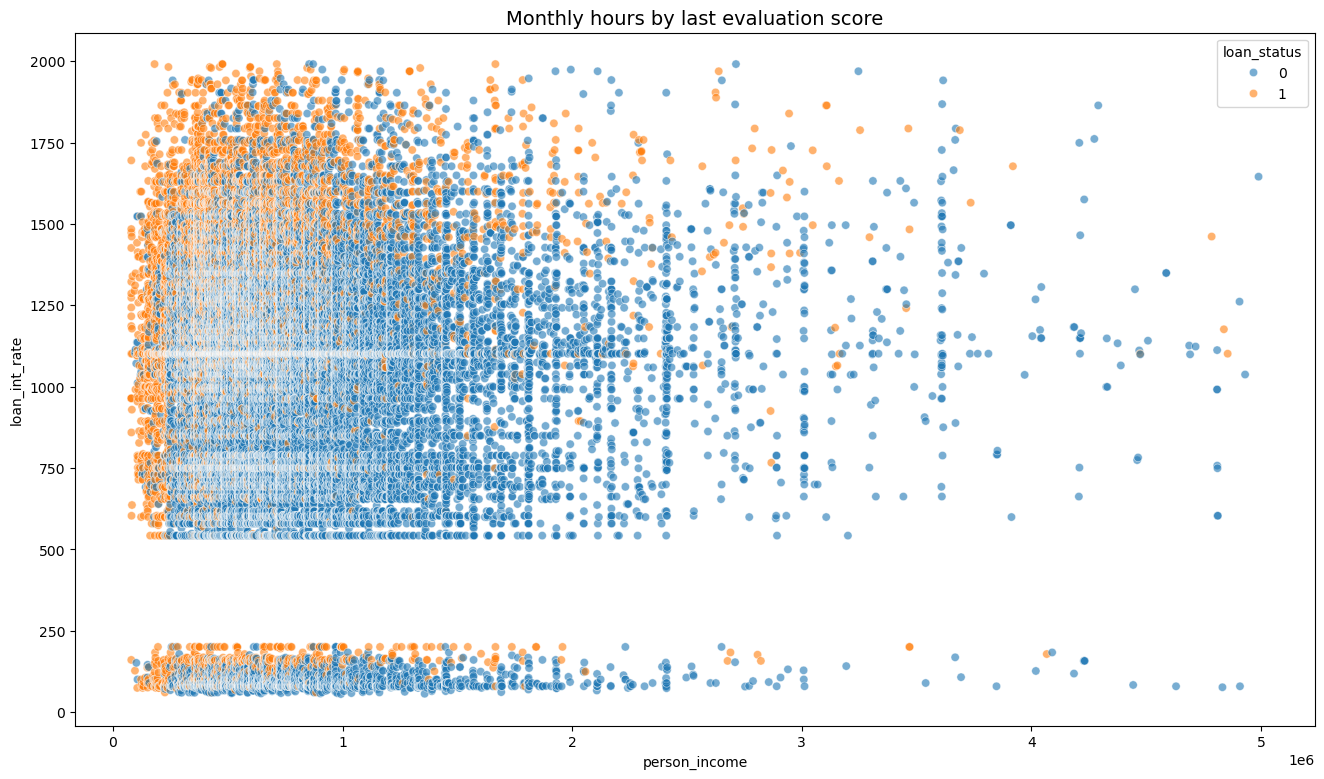

In [13]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df, x='person_income', y='loan_int_rate', hue='loan_status', alpha=0.6)
plt.title('Monthly hours by last evaluation score', fontsize='14');
plt.show();

C:\Users\rflip\AppData\Local\Temp\ipykernel_44484\3496522419.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].replace({'Yes': 1, 'No': 0})


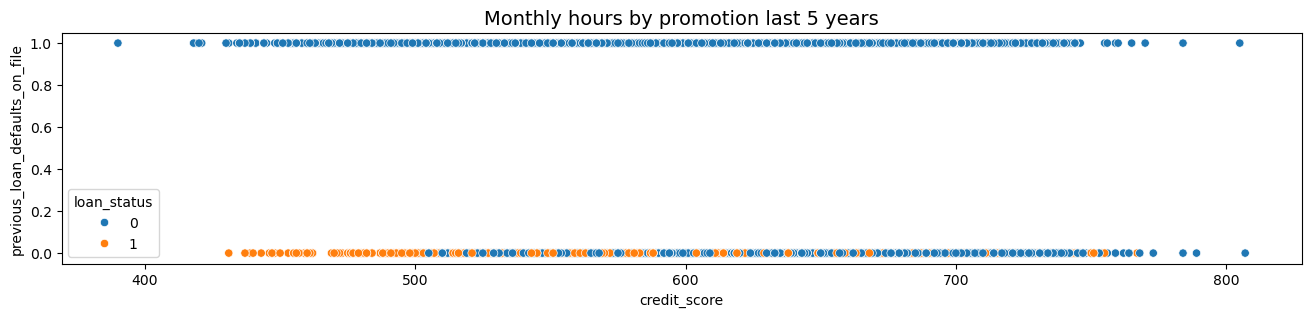

In [14]:
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].replace({'Yes': 1, 'No': 0})
plt.figure(figsize=(16, 3))
sns.scatterplot(data=df, x='credit_score', y='previous_loan_defaults_on_file', hue='loan_status')
plt.title('Monthly hours by promotion last 5 years', fontsize='14');
plt.show();

In [15]:
df["loan_intent"].value_counts()

loan_intent
EDUCATION            9142
MEDICAL              8526
VENTURE              7807
PERSONAL             7524
DEBTCONSOLIDATION    7120
HOMEIMPROVEMENT      4777
Name: count, dtype: int64

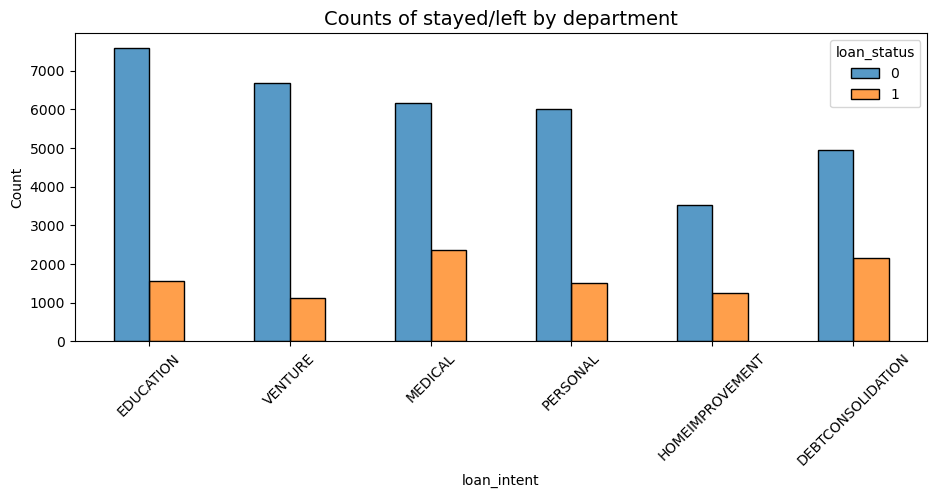

In [16]:
plt.figure(figsize=(11,4))
sns.histplot(data=df, x='loan_intent', hue='loan_status', discrete=1, 
             hue_order=[0, 1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/left by department', fontsize=14)
plt.show();

In [17]:
df1 = numeric_df = df.select_dtypes(include=['number'])
df1.head()

,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,tenure
0,80000,7,10000,963,12,30,598,0,1,7
1,80000,0,10000,964,12,40,630,0,1,2
2,80000,5,10000,964,12,40,631,0,1,6
3,80000,0,12000,1426,15,20,687,0,1,6
4,80000,9,12000,1273,15,90,580,0,1,3


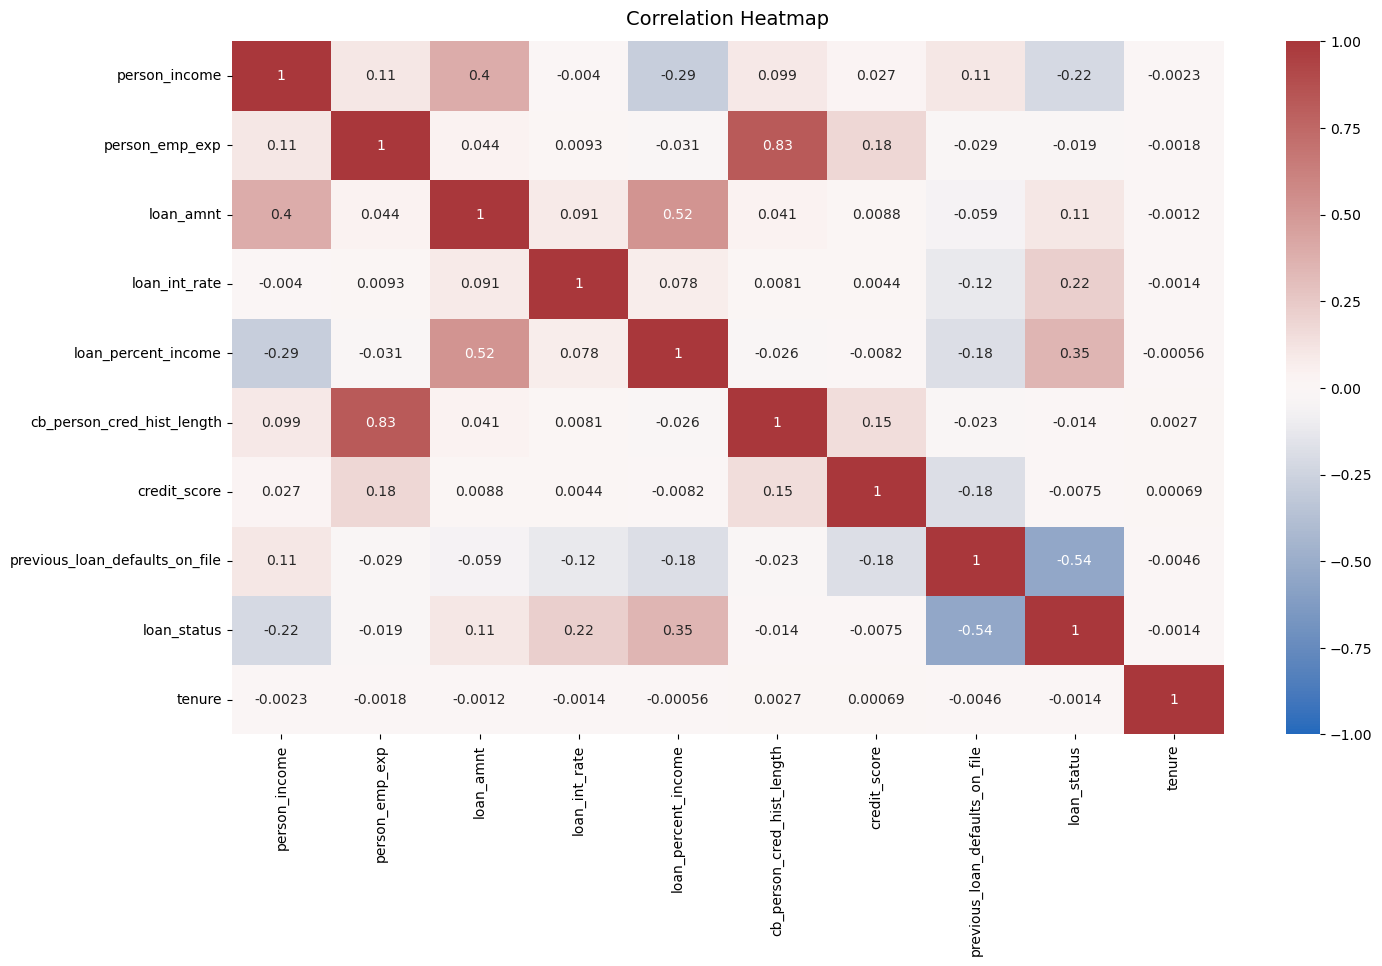

In [18]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df1.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.show();

In [19]:
df_enc = pd.get_dummies(df, prefix=['salary', 'intent'], columns = ['income_class', 'loan_intent'], drop_first=False)
df_enc = df_enc.replace({True: 1, False: 0})
# Display the new dataframe
df_enc.head()

C:\Users\rflip\AppData\Local\Temp\ipykernel_44484\3533096786.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_enc = df_enc.replace({True: 1, False: 0})


,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,tenure,salary_high,salary_low,salary_medium,intent_DEBTCONSOLIDATION,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,80000,7,10000,963,12,30,598,0,1,7,0,1,0,0,1,0,0,0,0
1,80000,0,10000,964,12,40,630,0,1,2,0,1,0,0,0,0,0,0,1
2,80000,5,10000,964,12,40,631,0,1,6,0,1,0,0,1,0,0,0,0
3,80000,0,12000,1426,15,20,687,0,1,6,0,1,0,0,0,0,1,0,0
4,80000,9,12000,1273,15,90,580,0,1,3,0,1,0,0,0,0,0,1,0


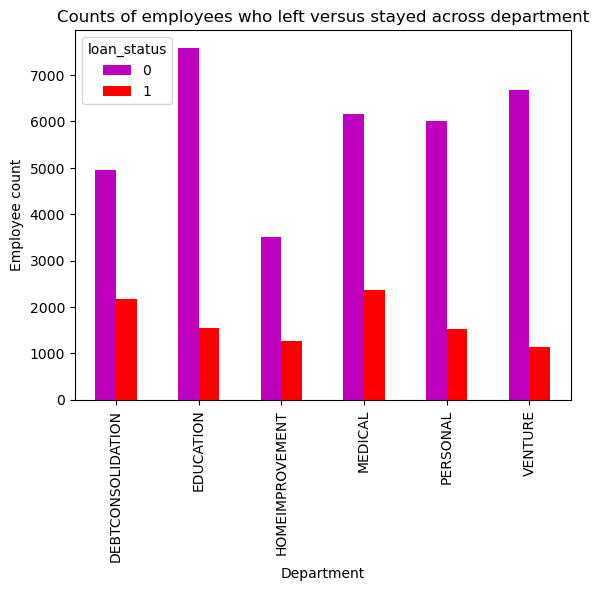

In [20]:
pd.crosstab(df["loan_intent"], df["loan_status"]).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

In [21]:
df_logreg = df_enc[(df_enc['credit_score'] >= lower_limit) & (df_enc['credit_score'] <= upper_limit)]

# Display first few rows of new dataframe
df_logreg.head()

,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,tenure,salary_high,salary_low,salary_medium,intent_DEBTCONSOLIDATION,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,80000,7,10000,963,12,30,598,0,1,7,0,1,0,0,1,0,0,0,0
1,80000,0,10000,964,12,40,630,0,1,2,0,1,0,0,0,0,0,0,1
2,80000,5,10000,964,12,40,631,0,1,6,0,1,0,0,1,0,0,0,0
3,80000,0,12000,1426,15,20,687,0,1,6,0,1,0,0,0,0,1,0,0
4,80000,9,12000,1273,15,90,580,0,1,3,0,1,0,0,0,0,0,1,0


In [22]:
y = df_logreg['loan_status']

# Display first few rows of the outcome variable
y.head() 

0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [23]:
X = df_logreg[['person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status', 'tenure', 'salary_low', 'salary_medium' , 'intent_DEBTCONSOLIDATION', 'intent_HOMEIMPROVEMENT', 'intent_EDUCATION', 'intent_MEDICAL', 'intent_PERSONAL', 'intent_VENTURE']]

# Display the first few rows of the selected features 
X.head()

,person_income,loan_amnt,loan_int_rate,loan_percent_income,credit_score,previous_loan_defaults_on_file,loan_status,tenure,salary_low,salary_medium,intent_DEBTCONSOLIDATION,intent_HOMEIMPROVEMENT,intent_EDUCATION,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,80000,10000,963,12,598,0,1,7,1,0,0,0,1,0,0,0
1,80000,10000,964,12,630,0,1,2,1,0,0,0,0,0,0,1
2,80000,10000,964,12,631,0,1,6,1,0,0,0,1,0,0,0
3,80000,12000,1426,15,687,0,1,6,1,0,0,0,0,1,0,0
4,80000,12000,1273,15,580,0,1,3,1,0,0,0,0,0,1,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [26]:
y_pred = log_clf.predict(X_test)

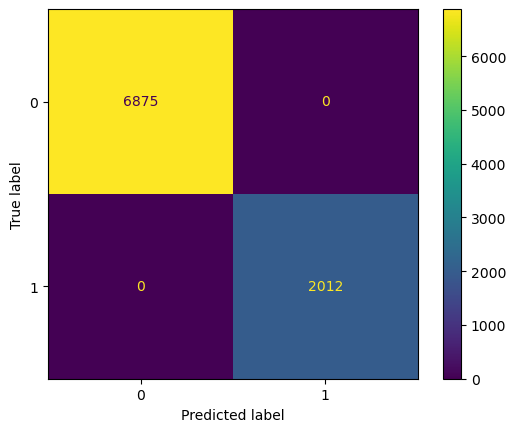

In [27]:
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [28]:
df_logreg['loan_status'].value_counts(normalize=True)

loan_status
0    0.777435
1    0.222565
Name: proportion, dtype: float64

In [29]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       1.00      1.00      1.00      6875
    Predicted would leave       1.00      1.00      1.00      2012

                 accuracy                           1.00      8887
                macro avg       1.00      1.00      1.00      8887
             weighted avg       1.00      1.00      1.00      8887



In [30]:
df2 = pd.get_dummies(df1)

In [31]:
y = df2['loan_status']

# Display the first few rows of `y`
y.head()

0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64

In [32]:
X = df2.drop('loan_status', axis=1)

# Display the first few rows of `X`
X.head()

,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,tenure
0,80000,7,10000,963,12,30,598,0,7
1,80000,0,10000,964,12,40,630,0,2
2,80000,5,10000,964,12,40,631,0,6
3,80000,0,12000,1426,15,20,687,0,6
4,80000,9,12000,1273,15,90,580,0,3


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Create train & validate data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

In [34]:
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Instantiate GridSearch dengan scoring dictionary
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')


In [35]:
%%time
tree1.fit(X_tr, y_tr)

CPU times: total: 19.2 s
Wall time: 24.9 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [36]:
tree1.best_params_

{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [37]:
tree1.best_score_

0.9457574681559717

In [38]:
def make_results(model_name: str, model_object, metric: str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc

    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
        'auc': 'mean_test_roc_auc',
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy',
    }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results['mean_test_roc_auc']
    f1 = best_estimator_results['mean_test_f1']
    recall = best_estimator_results['mean_test_recall']
    precision = best_estimator_results['mean_test_precision']
    accuracy = best_estimator_results['mean_test_accuracy']

    # Create table of results
    table = pd.DataFrame([{
        'Model': model_name,
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Accuracy': accuracy,
    }])

    return table


In [39]:
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,Model,AUC,Precision,Recall,F1,Accuracy
0,decision tree cv,0.945757,0.821087,0.690421,0.749931,0.897613


In [ ]:
rf = RandomForestClassifier(random_state=0)

cv_params = {
    'max_depth': [3, 5, 10, None], 
    'max_features': ['sqrt', 1.0], 
    'max_samples': [0.7, 1.0], 
    'min_samples_leaf': [1, 2, 3], 
    'min_samples_split': [2, 3, 4, 5], 
    'n_estimators': [100, 200]
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

rf1 = RandomizedSearchCV(
    rf, 
    param_distributions=cv_params, 
    scoring=scoring, 
    cv=4, 
    refit='roc_auc', 
    n_iter=20, 
    random_state=0
)

# Fit model
rf1.fit(X_train, y_train)

# Best Parameters and Scores
print("Best parameters:", rf1.best_params_)
print("Best ROC-AUC Score:", rf1.best_score_)

In [ ]:
path = C:\Users\rflip\OneDrive\Desktop\loan-approval

In [ ]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [ ]:
write_pickle(path, rf1, 'hr_rf1')
rf1 = read_pickle(path, 'hr_rf1')

In [ ]:
rf1.best_score_